# <div style = 'background:#0277BD; border:4; border-radius: 10px; font-size:120%; font-weight: bold;color:white; line-height: 1.2;'> <center> Histopathologic Cancer Detection <br />  </div>

In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
plt.rc('axes', titlesize=18)   
plt.rc('axes', labelsize=14)    
plt.rc('xtick', labelsize=13)    
plt.rc('ytick', labelsize=13)   
plt.rc('legend', fontsize=13)    
plt.rc('font', size=13)         
import seaborn as sns
sns.set_style('darkgrid') 
import plotly.express as px
from PIL import Image
from skimage import io
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 10px; line-height: 0.5;">Problem Description</div></center>
Histopathology is a type of pathology that deals with the examination of tissue changes characteristic of diseases. Pathologists use histopathology to evaluate the shape and structure of cells and tissue under a microscope, and develop a report of their findings that can include descriptions of the tissue, diagnosis, and prognosis. However, manual detection is tedious and tiring and likely to comprise human errors. In histopathologic cancer detection, deep learning algorithms have been applied to automate the process and increase accuracy in detecting cancerous cells and tissue. The aim of this mini-project is to use Convolution Neural Network (CNN) algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 10px; line-height: 0.5;">Dataset</div></center>
The dataset and its detailed information are available on [Kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data). The dataset is a slightly modified version of the [PatchCamelyon (PCam)](https://patchcamelyon.grand-challenge.org/) benchmark dataset. We are provided with a large number of small pathology images (TIF format) to classify. 
- The dataset consists of images in two folders: 
  - Training: 220,025 images
  - Test: 57,458 images
  - Each image has 96x96 pixels with 3 channels (RGB)  
- A train_labels.csv file that provides the ground truth for the images in the train folder (the image id and label)

The task is to predict the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue outside of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding to ensure consistent classification when applied to the whole image.

In [3]:
train_path = '../input/histopathologic-cancer-detection/train/'
test_path = '../input/histopathologic-cancer-detection/test/'

# let's confirm the number of images in the two folders
print(f"There are {len(os.listdir(train_path))} training samples.")
print(f"There are {len(os.listdir(test_path))} testing samples.")

There are 220025 training samples.
There are 57458 testing samples.


In [4]:
# the train_labels.csv table provides the ground truth for the images in the train folder (the image id and label)
# 1: cancerous; 0: non-cancerous
train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv', dtype=str)
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
train_labels.shape

(220025, 2)

In [6]:
# check for data types, and if any missing data
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


In [8]:
# the test data will be used later to test our model
test_data = pd.DataFrame({'id':os.listdir(test_path)})

# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 10px; line-height: 0.5;">Exploratory Data Analysis</div></center>

First, let's visualize a few images from the training set. 

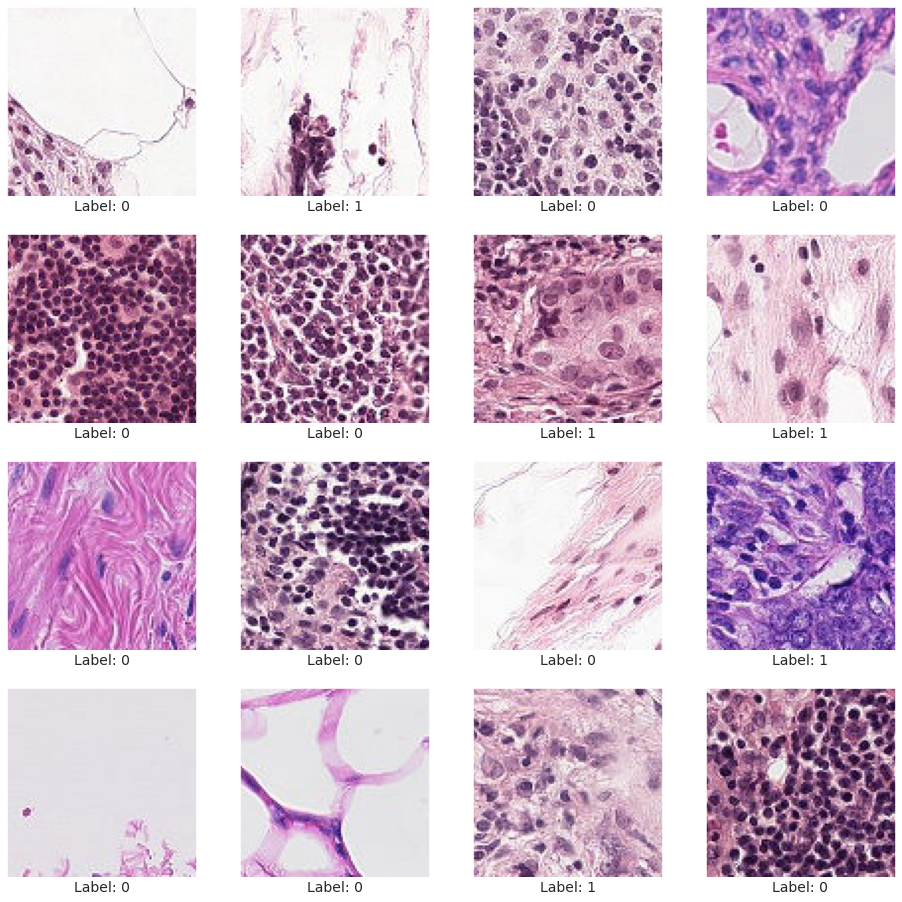

In [9]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for idx, axis in enumerate(ax.flat):
    file = str(train_path + train_labels.id[idx] + '.tif')
    image = io.imread(file)
    axis.imshow(image)
    axis.set(xticks=[], yticks=[], xlabel = f"Label: {train_labels.label[idx]}")

Check the distribution of categories (1: cancerous; 0: non-cancerous) to see if the dataset is balanced or not.

In [11]:
train_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

<AxesSubplot:title={'center':'Category distribution'}>

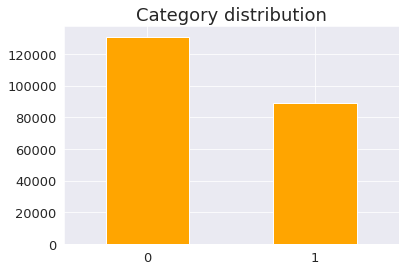

In [12]:
train_labels['label'].value_counts().plot(kind = 'bar', title = 'Category distribution', color = 'orange', rot = 0)

In [13]:
fig = px.pie(train_labels, values = train_labels['label'].value_counts().values, names = train_labels['label'].unique())
fig.update_layout(
    title={'text': "Category distribution pie chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.update_layout(legend=dict(y=0.99, x=0.7))
fig.show()

We can see that the training dataset is imbalanced becaude there are more images in the non-cancerous group (0) than that in the cancerous group (1).

To avoid issues associated with an imbalanced dataset, I will randomly select 89117 images from the non-cancerous group (0) to generate a balanced training set. 

In [15]:
train_0 = train_labels[train_labels['label']=='0']
train_1 = train_labels[train_labels['label']=='1']

# randomly select 89117 samples from the "train_0" group
train_0_resample = resample(train_0,replace=False, n_samples=train_1.shape[0], random_state=2023)

# combine "train_0_resample" and "train_1" to have a balanced dataset
train_balanced = pd.concat([train_0_resample, train_1]).reset_index(drop=True)

# shuffle the dataframe so that the model won't learn based on the image ordering of the input
train_balanced = shuffle(train_balanced, random_state = 2023)

Now we should have a balanced dataset. Let's check it again. 

0    89117
1    89117
Name: label, dtype: int64


<AxesSubplot:title={'center':'Category distribution'}>

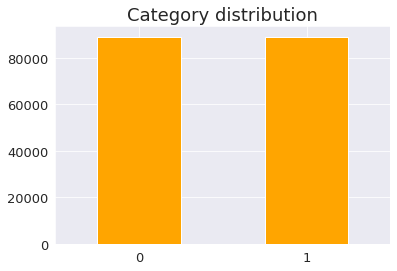

In [16]:
print(train_balanced['label'].value_counts())
train_balanced['label'].value_counts().plot(kind = 'bar', title = 'Category distribution', color = 'orange', rot = 0)

### More data preprocessing and plan of analysis

According to the dataset description, the dataset has been previously cleaned. There is no missing value. However, it is still important to check if it contains any duplicates. 

In [17]:
train_balanced.duplicated().sum()

0

For the balanced training set, we'll use 80% of the data to train models and use the rest 20% for validation before we test our model using the test set. 

In [18]:
train_df, valid_df = train_test_split(train_balanced, test_size=0.2, random_state=2023, stratify=train_balanced.label)

# add ".tif" to the image id
train_df['id'] = train_df['id'] + '.tif'
valid_df['id'] = valid_df['id'] + '.tif'

# make sure that the labels are strings
train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

To implement image **augmentation**, we'll use the Keras library, ImageDataGenerator. The images will be rescaled, i.e., the pixels will be divided by 255. We'll skip more complex augmentation for now for simplicity. We'll perform **normalization** during training. 

Briefly, we'll build two models, a basic one and a more complex one with more hyperparameter tuning. 

# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 10px; line-height: 0.5;">Model Architecture</div></center>

To solve this binary classification problem, we'll use Keras library, a high-level API of TensorFlow, to set up Convolution Neural Network (CNN) models. 

In [21]:
# Normalize the original data by divide by 255
datagen = ImageDataGenerator(rescale=1/255)

# image data from the training set
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col="id",
    y_col="label",
    batch_size=128,
    seed=2023,
    class_mode="binary",
    target_size=(48,48))   

# image data from the validation set
valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_path,
    x_col="id",
    y_col="label",
    batch_size=128,
    seed=2023,
    class_mode="binary",
    target_size=(48,48))   

Found 142587 validated image filenames belonging to 2 classes.
Found 35647 validated image filenames belonging to 2 classes.


## Create a basic CNN model
First, we'll set up a basic CNN model with the following structure:
- 2D Conv Layer
- 2D Conv Layer
- Max Pooling Layer
- 2D Conv Layer
- 2D Conv Layer
- Ave Pooling Layer
- Flatten
- Output with Sigmoid Activation

In [30]:
model_1 = Sequential()
    
model_1.add(Conv2D(filters=16, kernel_size=3))
model_1.add(Conv2D(filters=16, kernel_size=3))
# model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=2))

model_1.add(Conv2D(filters=32, kernel_size=3))
model_1.add(Conv2D(filters=32, kernel_size=3))
# model_1.add(Activation('relu'))
model_1.add(AveragePooling2D(pool_size=2))

model_1.add(Flatten())
model_1.add(Dense(1, activation='sigmoid'))
    
# build model 
model_1.build(input_shape=(128, 48, 48, 3))     
    
# compile
model_1.compile(loss='binary_crossentropy', metrics=['accuracy'])

# show summary
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (128, 46, 46, 16)         448       
_________________________________________________________________
conv2d_17 (Conv2D)           (128, 44, 44, 16)         2320      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (128, 22, 22, 16)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (128, 20, 20, 32)         4640      
_________________________________________________________________
conv2d_19 (Conv2D)           (128, 18, 18, 32)         9248      
_________________________________________________________________
average_pooling2d_4 (Average (128, 9, 9, 32)           0         
_________________________________________________________________
flatten_4 (Flatten)          (128, 2592)              

### Flowchart of the basic CNN model

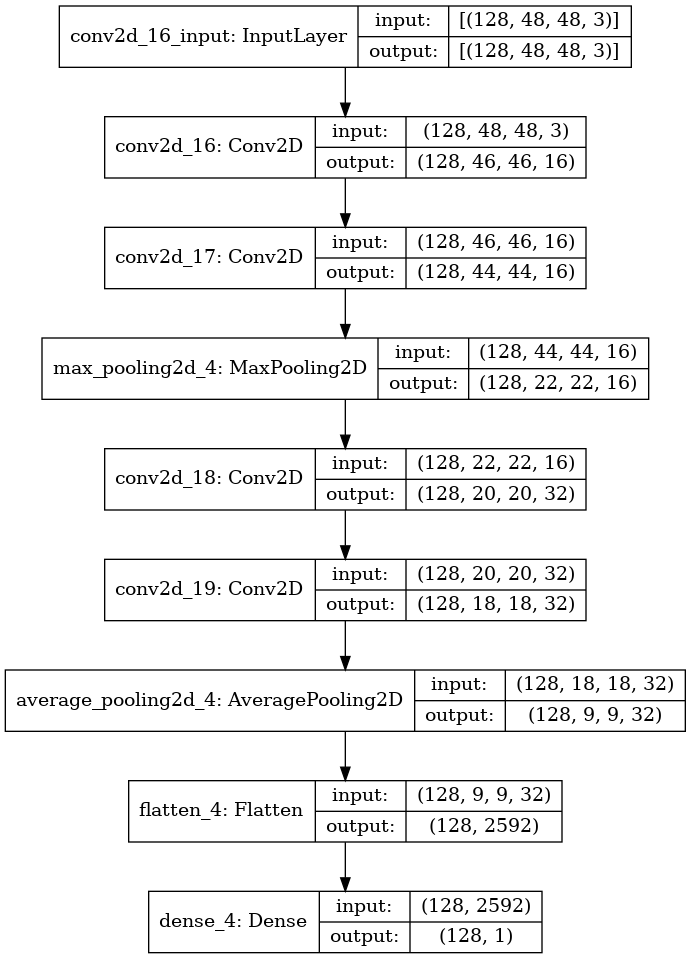

In [31]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

<a id = "title-seven"></a>
# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 12px; line-height: 0.6;">Results and Analysis</div></center>

Now we have a pretty simple CNN model. We'll train the model with 10 epochs and evaluate the model by checking the accuracy and loss. From the results, we'll have a better ideal of how to tune the hyperparameters and modify the architecture.

In [32]:
# train the model
history_model_1 = model_1.fit(train_generator,epochs = 10,validation_data = valid_generator)

Epoch 1/10
1114/1114 [==============================] - 508s 455ms/step - loss: 0.6137 - accuracy: 0.6780 - val_loss: 0.5632 - val_accuracy: 0.7348
Epoch 2/10
1114/1114 [==============================] - 430s 386ms/step - loss: 0.5587 - accuracy: 0.7325 - val_loss: 0.5134 - val_accuracy: 0.7653
Epoch 3/10
1114/1114 [==============================] - 395s 355ms/step - loss: 0.5181 - accuracy: 0.7570 - val_loss: 0.4805 - val_accuracy: 0.7826
Epoch 4/10
1114/1114 [==============================] - 392s 352ms/step - loss: 0.4963 - accuracy: 0.7700 - val_loss: 0.4749 - val_accuracy: 0.7839
Epoch 5/10
1114/1114 [==============================] - 385s 345ms/step - loss: 0.4845 - accuracy: 0.7772 - val_loss: 0.4826 - val_accuracy: 0.7732
Epoch 6/10
1114/1114 [==============================] - 381s 342ms/step - loss: 0.4753 - accuracy: 0.7813 - val_loss: 0.4755 - val_accuracy: 0.7790
Epoch 7/10
1114/1114 [==============================] - 387s 347ms/step - loss: 0.4683 - accuracy: 0.7870 - val_

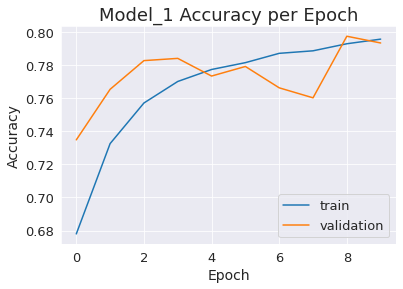

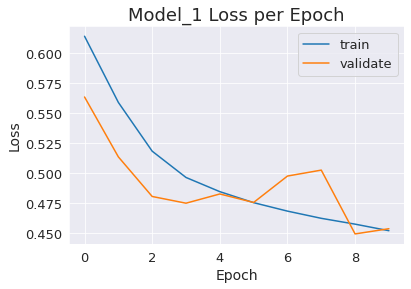

In [33]:
# accuracy vs epoch 
plt.plot(history_model_1.history['accuracy'])
plt.plot(history_model_1.history['val_accuracy'])
plt.title('Model_1 Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# loss vs epoch
plt.plot(history_model_1.history['loss'])
plt.plot(history_model_1.history['val_loss'])
plt.title('Model_1 Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

## Buld a more complex (better) model

The first model is not bad, given how simple it is! In the second model, we'll make some adjustments to try to improve the performance 
which will help the model to converge better, reduce overfitting, and keep the model from being too computationally intensive.

- **Hidden layer activations:** rectified linear regression (ReLU) will be used as the hidden layer activation function 
- **Batch normalization:** it will make the model less sensitive to small changes in hyperparameters
- **Dropout:** we will set dropout at 0.4 which will randomly select some weights to set as 0 
- **Optimization:** we will use adaptive moment estimation (Adam) to optimize the model and the learning rate will be set as 1e-4

We will also add AUC as another metric to better evaluate this model.


In [41]:
model_2 = Sequential()
    
model_2.add(Conv2D(filters=16, kernel_size=3))
model_2.add(Conv2D(filters=16, kernel_size=3))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=2))

model_2.add(Conv2D(filters=32, kernel_size=3))
model_2.add(Conv2D(filters=32, kernel_size=3))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(AveragePooling2D(pool_size=2))

model_2.add(Conv2D(filters=64, kernel_size=3))
model_2.add(Conv2D(filters=64, kernel_size=3))
model_2.add(Activation('relu'))
model_2.add(BatchNormalization())
model_2.add(AveragePooling2D(pool_size=2))

model_2.add(Flatten())
model_2.add(Dropout(0.4))
model_2.add(Dense(32))
model_2.add(BatchNormalization())
model_2.add(Dense(1, activation='sigmoid'))
    
# build model 
model_2.build(input_shape=(128, 48, 48, 3))     
    
# compile
opt_adm = tf.keras.optimizers.Adam(learning_rate = 1e-4)
metric_AUC = tf.keras.metrics.AUC()
model_2.compile(loss='binary_crossentropy', optimizer=opt_adm, metrics=['accuracy', metric_AUC])

# summary
model_2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (128, 46, 46, 16)         448       
_________________________________________________________________
conv2d_45 (Conv2D)           (128, 44, 44, 16)         2320      
_________________________________________________________________
activation_20 (Activation)   (128, 44, 44, 16)         0         
_________________________________________________________________
batch_normalization_14 (Batc (128, 44, 44, 16)         64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (128, 22, 22, 16)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (128, 20, 20, 32)         4640      
_________________________________________________________________
conv2d_47 (Conv2D)           (128, 18, 18, 32)        

### Flowchart of the more complex CNN model

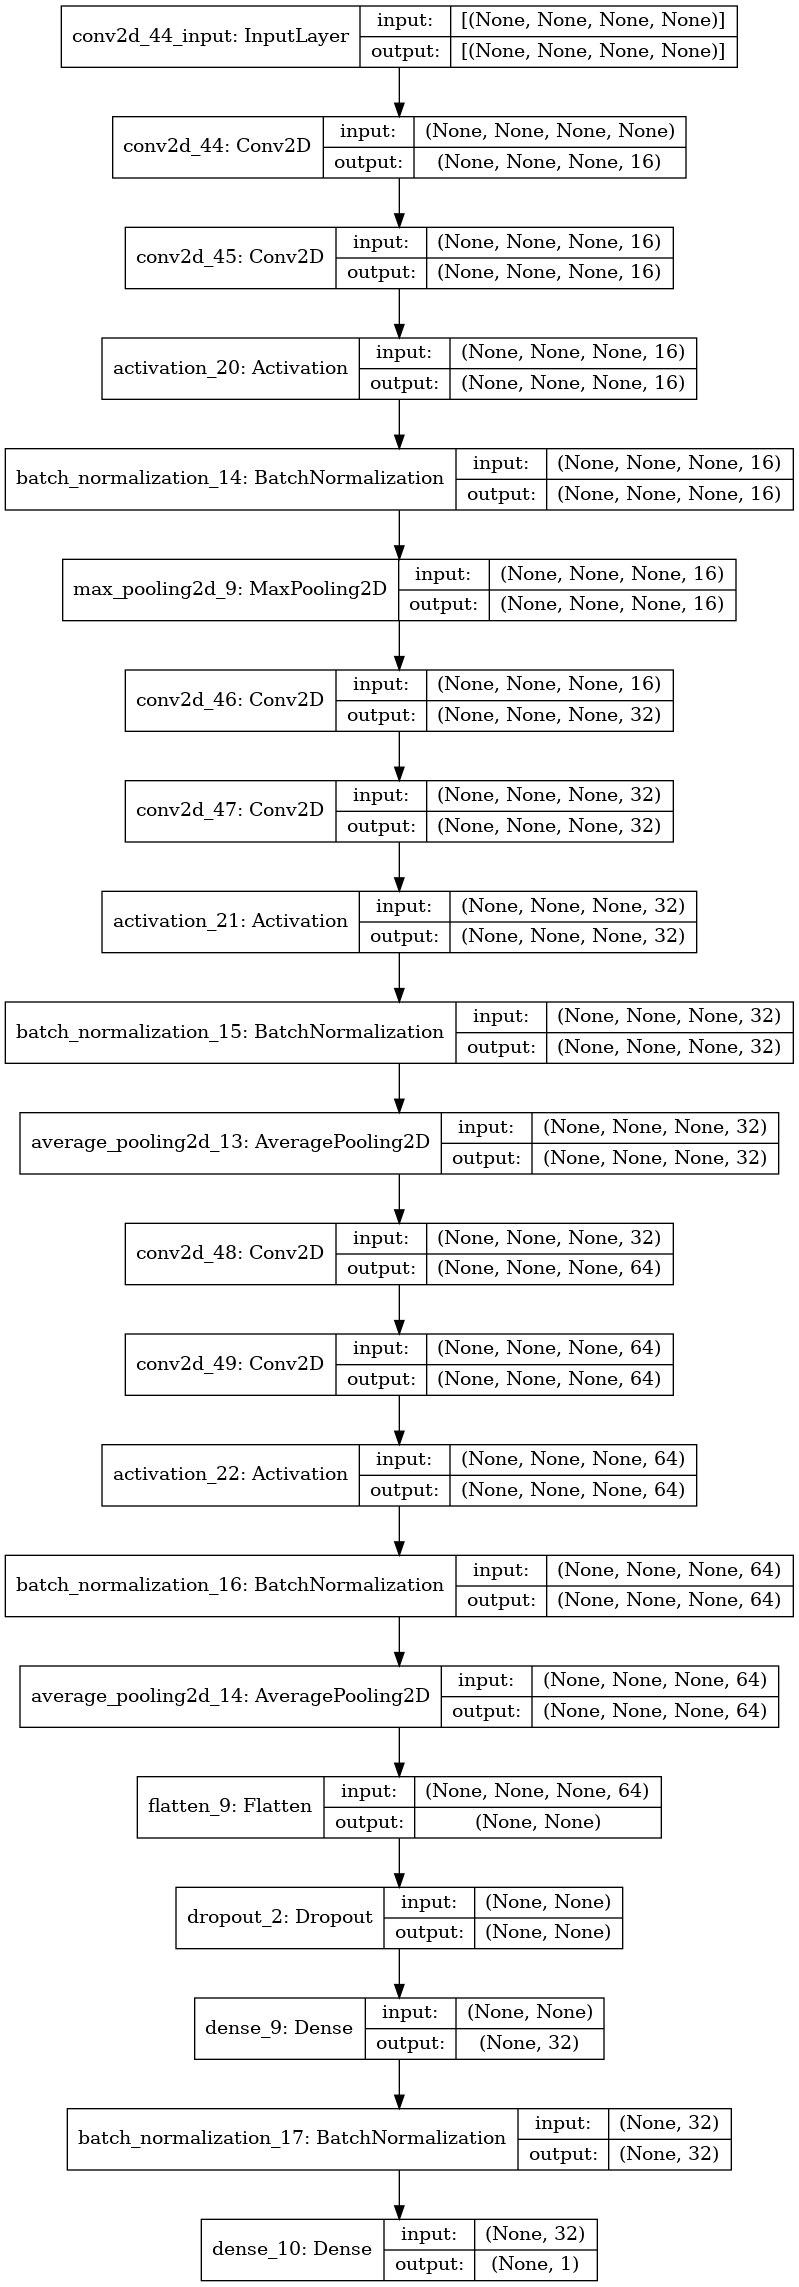

In [49]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

In [42]:
history_model_2 = model_2.fit(train_generator, epochs = 10, validation_data = valid_generator)

Epoch 1/10
1114/1114 [==============================] - 384s 343ms/step - loss: 0.4565 - accuracy: 0.7924 - auc_2: 0.8683 - val_loss: 0.4088 - val_accuracy: 0.8184 - val_auc_2: 0.8961
Epoch 2/10
1114/1114 [==============================] - 403s 362ms/step - loss: 0.3998 - accuracy: 0.8226 - auc_2: 0.8999 - val_loss: 0.4043 - val_accuracy: 0.8177 - val_auc_2: 0.9006
Epoch 3/10
1114/1114 [==============================] - 420s 377ms/step - loss: 0.3689 - accuracy: 0.8366 - auc_2: 0.9155 - val_loss: 0.3526 - val_accuracy: 0.8454 - val_auc_2: 0.9268
Epoch 4/10
1114/1114 [==============================] - 405s 364ms/step - loss: 0.3510 - accuracy: 0.8471 - auc_2: 0.9239 - val_loss: 0.4078 - val_accuracy: 0.8277 - val_auc_2: 0.9125
Epoch 5/10
1114/1114 [==============================] - 430s 386ms/step - loss: 0.3386 - accuracy: 0.8542 - auc_2: 0.9294 - val_loss: 0.3711 - val_accuracy: 0.8394 - val_auc_2: 0.9165
Epoch 6/10
1114/1114 [==============================] - 481s 432ms/step - loss: 

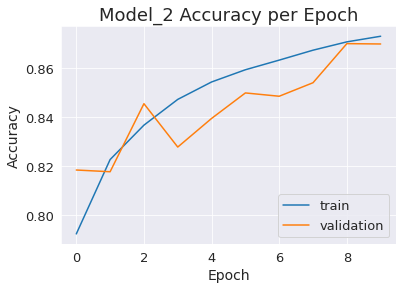

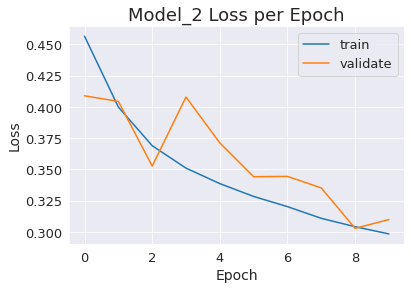

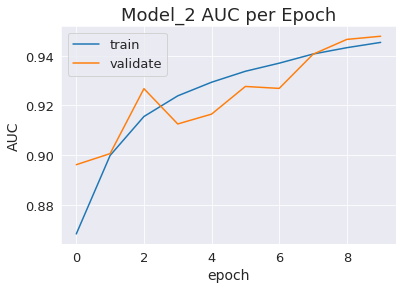

In [46]:
# accuracy vs epoch 
plt.plot(history_model_2.history['accuracy'])
plt.plot(history_model_2.history['val_accuracy'])
plt.title('Model_2 Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# loss vs epoch
plt.plot(history_model_2.history['loss'])
plt.plot(history_model_2.history['val_loss'])
plt.title('Model_2 Loss per Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

# plot model ROC per epoch
plt.plot(history_model_2.history['auc_2'])
plt.plot(history_model_2.history['val_auc_2'])
plt.title('Model_2 AUC per Epoch')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

We can see that the second model is much better than the first one! As mentioned earlier, we added batch normalization, ReLU activation functions, a drop layer, and an optimizer. These helped the model to converge better, reduce overfitting, and speed up the training time. Also, I tried to add another set of the hidden layer, but the model would require much more time to run and the system would run out of memory (data not shown here). 

Now it is time to test its performance against the test data!

### Test model_2 against the test data

In [47]:
# image data from the test set
datagentest = ImageDataGenerator(rescale=1/255)

test_gen = datagentest.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(48,48),         
    batch_size=1,
    shuffle=False,
    class_mode=None)  

Found 57458 validated image filenames.


In [48]:
# create the submission file
prediction = model_2.predict(test_gen, verbose=1)
prediction = np.transpose(prediction)[0]
submission = pd.DataFrame()
submission['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission['label'] = list(map(lambda x: 0 if x < 0.5 else 1, prediction))
submission.to_csv('submission.csv', index=False)

57458/57458 [==============================] - 619s 11ms/step


<a id = "title-seven"></a>
# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 12px; line-height: 0.6;">Conclusion</div></center>

In this mini-project, both models performed reasonably well given that they are relatively simple. After comparing the two models, we can see that hyperparameter tuning is an important step to improve the model's performance. Deep learning can be a powerful tool to aid in cancer diagnosis. 

If time and GPU allowed, I would like to try other options to further improve the model. 
- Based on the results above, it seems that more epochs may improve the performance. 
- More hyperparameter tuning for factors such as the number of hidden layers, filter size, stride, and activation functions. 
- The current dataset is large, but more data for training may further improve the generalization of the model.
- Apply augmentation to help the model learn more information from the training data. There are multiple tools available in the Keras library, such as RandomFlip, RandomZoom, and RandomRotation.
- If some well-trained models are available based on similar tasks, using the pre-trained model as a starting point may speed up training and improve the performance. 

# <center><div style="border-radius : 10px; background-color: #0277BD; color: white; padding: 10px; line-height: 0.5;">Reference</div></center>
- https://www.frontiersin.org/research-topics/26934/the-role-of-histopathology-in-cancer-diagnosis-and-prognosis
- Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd edition)
- https://www.kaggle.com/code/mattison/cancer-cnn-detection/notebook
- https://github.com/karansangha/dtsa5511-week3-cancer-detection/blob/main/Histopathologic%20Cancer%20Detection.ipynb
